In [2]:
# IMPORTS

import cv2
import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread('horse.jpg')

(415, 642, 3)
[[[0.04991089 0.04991089 0.03887064]
  [0.04404621 0.04404621 0.04404621]
  [0.03027249 0.03027249 0.03887064]]

 [[0.04404621 0.04404621 0.04404621]
  [0.03887064 0.03887064 0.04991089]
  [0.02671537 0.02671537 0.04404621]]

 [[0.03027249 0.03027249 0.03887064]
  [0.02671537 0.02671537 0.04404621]
  [0.01836119 0.01836119 0.03887064]]]


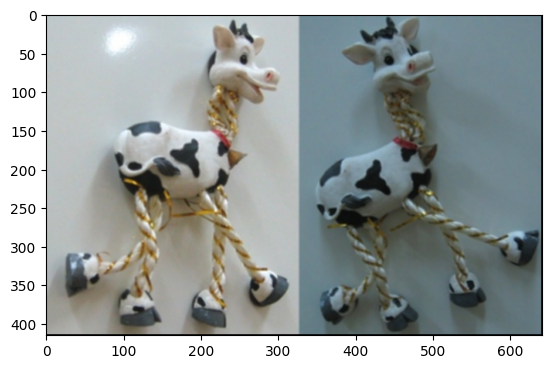

In [5]:
# 1. Gaussian kernel smoothing

print(image.shape)

sigma = 2

def gaussian(x, y, k_size):
    return (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - k_size//2)**2 + (y - k_size//2)**2) / (2 * sigma**2))

def filter2D(img, kernel, k_size):
    img_height, img_width, channels = img.shape
    filtered_img = np.zeros((img.shape), dtype=float) # init result img
    k_middle = k_size // 2
    
    # iterate through pixels in img
    for c in range(channels):
        for i in range(img_height - k_size + 1):
            for j in range(img_width - k_size + 1):
                k_image = img[i:i+k_size, j:j+k_size, c] # grab section of image using filter
                filtered_img[i+k_middle, j+k_middle, c] = np.sum(k_image * kernel) # assign weighted sum to middle of kernel's img

    return filtered_img


# np.fromfunction() returns matrix based on function inputted
# creates our kernel essentially
k_size = 3
kernel = np.fromfunction(gaussian, (k_size, k_size, k_size))
kernel /= np.sum(kernel) # normalize kernel
print(kernel)

smoothed = filter2D(image, kernel, k_size).astype(np.uint8)
smoothed = cv2.cvtColor(smoothed, cv2.COLOR_BGR2RGB)

plt.imshow(smoothed)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


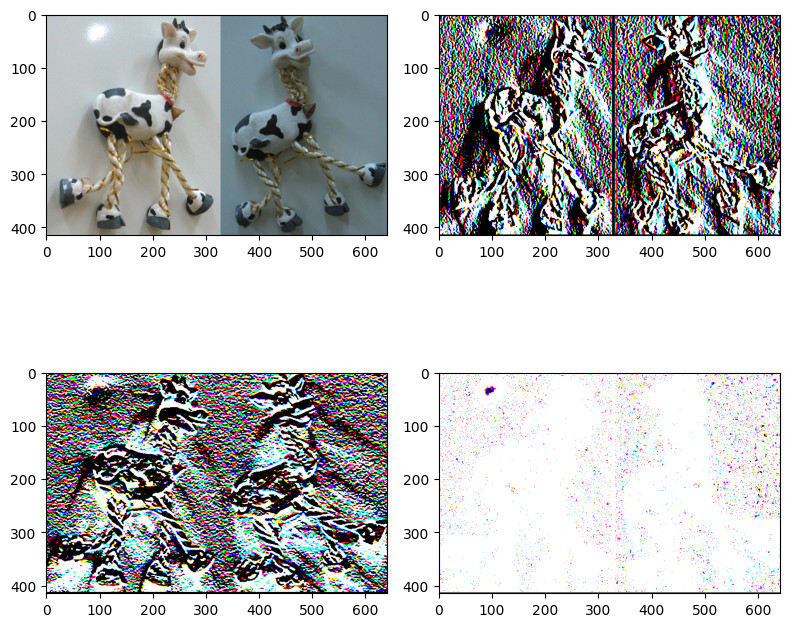

In [12]:
# 2. Derivatives of smoothed img

G_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)
G_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float)

Ix = filter2D(smoothed, G_x, 3)
Iy = filter2D(smoothed, G_y, 3)

# magnitude of gradient
magnitude = np.sqrt(Ix**2 + Iy**2)

# Visualizing: original, gradient in x, gradient in y, and magnitude
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(image, cmap='gray')
plt.subplot(222)
plt.imshow(Ix, cmap='gray')
plt.subplot(223)
plt.imshow(Iy, cmap='gray')
plt.subplot(224)
plt.imshow(magnitude, cmap='gray')
plt.tight_layout()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.00000e+00  0.00000e+00  0.00000e+00]
  [ 0.00000e+00  0.00000e+00  0.00000e+00]
  [ 0.00000e+00  0.00000e+00  0.00000e+00]
  ...
  [ 0.00000e+00  0.00000e+00  0.00000e+00]
  [ 0.00000e+00  0.00000e+00  0.00000e+00]
  [ 0.00000e+00  0.00000e+00  0.00000e+00]]

 [[ 0.00000e+00  0.00000e+00  0.00000e+00]
  [ 3.27183e+05  3.56409e+05  3.62403e+05]
  [-2.28900e+03 -2.38500e+03 -8.03000e+02]
  ...
  [ 8.80000e+02 -5.35000e+02  0.00000e+00]
  [-1.09560e+05 -1.60800e+05 -1.91844e+05]
  [ 0.00000e+00  0.00000e+00  0.00000e+00]]

 [[ 0.00000e+00  0.00000e+00  0.00000e+00]
  [ 2.28900e+03  1.59200e+03  4.01500e+03]
  [-1.60000e+01 -8.00000e+00 -1.50000e+01]
  ...
  [ 3.00000e+00  3.00000e+00  1.00000e+00]
  [ 2.20500e+03  1.07200e+03  1.16800e+03]
  [ 0.00000e+00  0.00000e+00  0.00000e+00]]

 ...

 [[ 0.00000e+00  0.00000e+00  0.00000e+00]
  [ 1.98900e+03  1.98900e+03  1.96500e+03]
  [ 1.60000e+01  1.60000e+01  1.60000e+01]
  ...
  [-1.00000e+00 -0.00000e+00 -3.30000e+01]
  [-8.00000e+02 -9

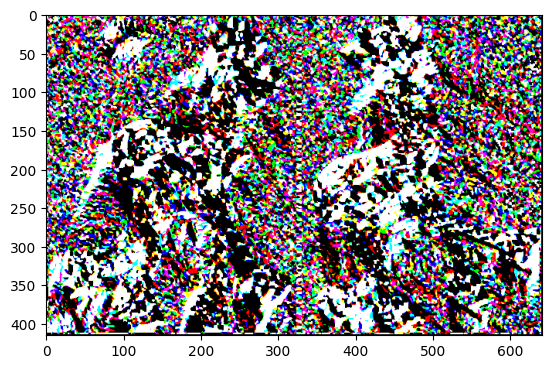

In [15]:
# 3. and 4. Compute derivatives at each pixel and smooth them

Ixx = Ix * Ix
Iyy = Iy * Iy
Ixy = Ix * Iy

Ixx_smooth = filter2D(Ixx, kernel, k_size)
Iyy_smooth = filter2D(Iyy, kernel, k_size)
Ixy_smooth = filter2D(Ixy, kernel, k_size)

print(Ixy)
plt.imshow(Ixy_smooth, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(415, 642, 3, 2, 2)
(415, 642, 3)
(415, 642, 3)


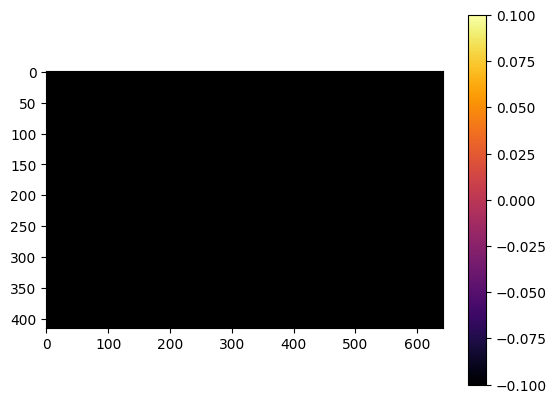

In [55]:
# 5. and 6. Define H(x,y) and compute response

k = 0.04 # Harris response hyperparameter for controlling sensitivity
H = np.empty((smoothed.shape[0], smoothed.shape[1], smoothed.shape[2], 2, 2), dtype=np.float32)

# H(x,y) for each pixel
for c in range(smoothed.shape[2]):
    for i in range(smoothed.shape[0]):
        for j in range(smoothed.shape[1]):
            H[i, j, c] = np.array([[Ixx[i, j, c], Ixy[i, j, c]], [Ixy[i, j, c], Iyy[i, j, c]]])

print(H.shape)

# compute harris response
detH = np.linalg.det(H)
print(detH.shape)
traceH = np.trace(H, axis1=3, axis2=4)
print(traceH.shape)
R = detH - k * (traceH ** 2)

plt.imshow(R, cmap='inferno')
plt.colorbar()